# Siamese neural networks

This notebook is the first part of the paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) coded with PyTorch framework. 

- Siamese neural networks -> image similarity task

References:
- [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- [omniglot](https://github.com/brendenlake/omniglot)
- [keras-oneshot](https://github.com/sorenbouma/keras-oneshot)


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import cv2

In [7]:
sys.path.append("..")

In [12]:
HAS_GPU = False

## Model

- 2 convolutional neural networks with shared weights
- standard verification task : discriminate between the class-identity of image pairs
    - `{ball, dog} ---[Siamese network] --- false`
    - `{ball1, ball2} ---[Siamese network] --- true`
    
### CNN

#### Architecture 

Single image encoding CNN is defined as 
```
---[C|R]---[P] ->-[C|R]---[P]->-[C|R]---[P]->-[C|R]---[Flatten]---[FC|Sigmoid]---
   64      2x2     128    2x2    128    2x2    256
   10x10           7x7           4x4           4x4
```
where `C` is 2D convolution, `R` - ReLU activation, `P` - max-pooling, `FC` - fully-connected layer

Complete network is defined as
```
input1 --- [CNN]---\
                 [merge]---[Dense]---output
input2 --- [CNN]---/
```
where `merge` is L1 component-wise distance between vectors


#### Weight initialization

- Convolution layers: 
    - Kernel : normal distribution with $\mu=0$ and $\sigma=10^{-2}$
    - Bias : normal distribution with $\mu=0.5$ and $\sigma=10^{-2}$
- Fully-connected layers: 
    - Kernel : normal distribution with $\mu=0$ and $\sigma=2 \cdot 10^{-1}$
    - Bias : normal distribution with $\mu=0.5$ and $\sigma=10^{-2}$


In [4]:
import torch
from torch.nn import Module, Sequential
from torch.nn import Linear, Conv2d, MaxPool2d, Sigmoid, ReLU
from torch.autograd import Variable
torch.__version__

'0.4.0a0+2c39f3d'

In [8]:
from common_utils.nn_utils import print_trainable_parameters

In [9]:
class Flatten(Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [10]:
class Net(Module):
    
    def __init__(self, input_shape):
        """
        :param input_shape: input image shape, (h, w, c)
        """
        super(Net, self).__init__()
        
        self.features = Sequential(            
            Conv2d(input_shape[-1], 64, kernel_size=10),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),
            
            Conv2d(64, 128, kernel_size=7),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),

            Conv2d(128, 128, kernel_size=4),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),            
            
            Conv2d(128, 256, kernel_size=4),
            ReLU()        
        )
        
        # Compute number of input features for the last fully-connected layer
        input_shape = (1, ) + input_shape[::-1]
        x = Variable(torch.rand(input_shape), requires_grad=False)
        x = self.features(x)
        x = Flatten()(x)
        n = x.size()[1]
        
        self.classifier = Sequential(
            Flatten(),
            Linear(n, 4096),
            Sigmoid()
        )     
        
    def forward(self, x):        
        x = self.features(x)
        x = self.classifier(x)
        return x

In [11]:
class SiameseNetworks(Module):
    
    def __init__(self, input_shape):
        """
        :param input_shape: input image shape, (h, w, c)
        """
        super(SiameseNetworks, self).__init__()
        self.net = Net(input_shape)
                
        self.classifier = Sequential(
            Linear(4096, 1, bias=False),
            Sigmoid()
        )        
        self._weight_init()  
        
    def _weight_init(self):
        for m in self.modules():
            if isinstance(m, Conv2d):
                m.weight.data.normal_(0, 1e-2)
                m.bias.data.normal_(0.5, 1e-2)
            elif isinstance(m, Linear):
                m.weight.data.normal_(0, 2.0*1e-1)
                if m.bias is not None:
                    m.bias.data.normal_(0.5, 1e-2) 
    
    def forward(self, x1, x2):        
        x1 = self.net(x1)
        x2 = self.net(x2)        
        # L1 component-wise distance between vectors:
        x = torch.pow(torch.abs(x1 - x2), 2.0)      
        return self.classifier(x)

In [13]:
siamese_net = SiameseNetworks(input_shape=(105, 105, 1))
if HAS_GPU and torch.cuda.is_available():
    siamese_net = siamese_net.cuda()

In [14]:
print_trainable_parameters(siamese_net)

net.features.0.weight torch.Size([64, 1, 10, 10])
net.features.0.bias torch.Size([64])
net.features.3.weight torch.Size([128, 64, 7, 7])
net.features.3.bias torch.Size([128])
net.features.6.weight torch.Size([128, 128, 4, 4])
net.features.6.bias torch.Size([128])
net.features.9.weight torch.Size([256, 128, 4, 4])
net.features.9.bias torch.Size([256])
net.classifier.1.weight torch.Size([4096, 9216])
net.classifier.1.bias torch.Size([4096])
classifier.0.weight torch.Size([1, 4096])

Total number of trainable parameters:  38951744


In [16]:
input_shape = (2, 1, 105, 105)
x = Variable(torch.rand(input_shape), requires_grad=False)
if HAS_GPU and torch.cuda.is_available():
    x = x.cuda()
y = siamese_net(x, x)
y.size()

torch.Size([2, 1])

In [17]:
from common_utils.nn_utils import make_dot

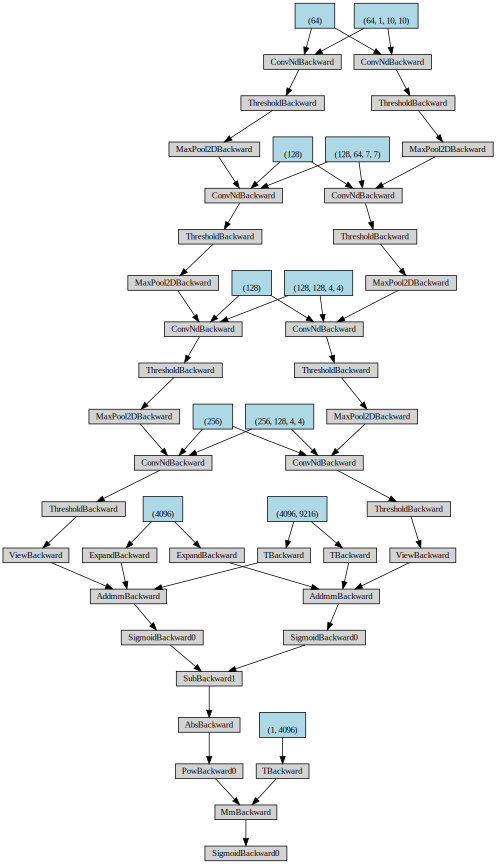

In [19]:
make_dot(y)